In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from qiskit.circuit import Parameter
from qiskit.opflow import CircuitStateFn
from qiskit import QuantumCircuit, BasicAer

from fisherman.randomized import randomized_measurement_overlap

# QFI

> Implementation of the method introduced in [this paper](https://arxiv.org/pdf/2104.00519.pdf).

In [ ]:
n_qubits = 1
backend = BasicAer.get_backend('statevector_simulator')

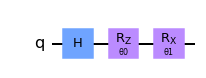

In [ ]:
theta0, theta1 = Parameter('θ0'), Parameter('θ1')
qc = QuantumCircuit(n_qubits)
qc.h(0)
qc.rz(theta0, 0)
qc.rx(theta1, 0)
qc.draw('mpl')

In [ ]:
state = CircuitStateFn(qc)
param_values = {theta0: np.pi/4, theta1: 0.1}
dtheta = np.round(np.arange(-0.1, 0.1, 0.01), 3)

In [ ]:
n_params, n_dth = len(state.parameters), len(dtheta)
params = state.primitive.parameters
qfi = np.zeros((n_params, n_params))
idx0 = np.argwhere(dtheta == 0).squeeze()

In [ ]:
def sub_qfi(x, qfi): return qfi*x**2

for i, param in enumerate(params):
        param_dict = {p: [v]*n_dth for p, v in param_values.items()}
        param_dict[param] = [param_values[param] + dth for dth in dtheta]
        overlap = randomized_measurement_overlap(state, param_dict=param_dict, n_rnd=256, local=False)

        if np.max(overlap) > 1: 
            overlap /= np.max(overlap)
        super_fidelity = overlap[idx0] + np.sqrt((1-overlap[idx0, idx0])*(1-overlap.diagonal()))
        bures_distance = 8*(1 - np.sqrt(super_fidelity))

        est_qfi, _ = curve_fit(sub_qfi, dtheta, bures_distance)
        qfi[i, i] = est_qfi

In [ ]:
qfi

array([[1.36533357, 0.        ],
       [0.        , 0.18256721]])